In [110]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, action_learner_search, value_estimator
from rl import block_movement_env
from rl import discrete_value_estimator as  dve
from rl import discrete_action_learner as dal


### RELOAD modules here
reload(config)
reload(value_estimator)
reload(config)
reload(block_movement_env)
reload(action_learner_search)
reload(progress_learner)
reload(dal)
reload(dve)


### AUXILIARY CODE
discretized_space = [0.18, 0.36, 0.72]
discretized_rotation = np.pi/8 

uniform_space = dal.MultiDiscreteNoZero( [(-len(discretized_space), len(discretized_space)), 
            (-len(discretized_space), len(discretized_space)), 
            (0, int((np.pi/2) // discretized_rotation)) ], (0,2) )

def action_policy ( state, policy_estimator, no_of_actions, verbose, session ):
    return dal.epsilon_greedy_action_2( state, policy_estimator, uniform_space, no_of_actions = no_of_actions, verbose= verbose,
                                       session = session, epsilon_1 = 0.6, epsilon_2 = 0 )


### MAIN CODE
tf.reset_default_graph()

c = config.Config()
c.num_episodes = 10

global_step = tf.Variable(0, name="global_step", trainable=False)


policy_est = dve.DiscretePolicyEstimator(c)
value_est = value_estimator.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load('../' + p_name)

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=True, name = projects[project_name].name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, '../progress_' + project_name + '.mod.1')

D:\git\learn-to-perform\rl\block_movement_env.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Anaconda3

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/Variable:0
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
model/SlideAround/beta1_power:0
model/SlideAround/beta2_power:0
model/SlideAround/model/SlideAround/linear/weight/Adam:0
model/SlideAround/model/SlideAround/linear/weight/Adam_1:0
model/SlideAround/model/SlideAround/linear/bias/Adam:0
model/SlideAround/model/SlideAround/linear/bias/Adam_1:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/

In [114]:
c.num_episodes = 100
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 10)

past_envs, stats = action_ln.policy_learn(action_policy, breadth = 2, verbose = True,
                                          choice = 'REINFORCE', default = True)

(array([-0.10395521,  0.02418613,  0.20038415], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.10395521  0.02418613  0.20038415]
 [-0.10395521  0.02418613  0.20038415]]
(array([-0.10395521,  0.02418613,  0.20038415], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 1/100 (0.04612691327929497)
(array([-0.06384867,  0.06854869,  0.14547044], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.06384867  0.06854869  0.14547044]
 [-1.          3.          0.        ]]
(array([-0.06384867,  0.06854869,  0.14547044], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.78958379,  0.32463301,  0.6       ]), 0.614378

action = (array([-0.03899562,  0.18385871,  0.6       ]), 0.53325766)
best reward = 0.53
best_action = (array([-0.03899562,  0.18385871,  0.6       ]), 0.53325766, False)
Step 1 @ Episode 4/100 (0.5793845765292645)
(array([0.00638304, 0.10396906, 0.03094602], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.00638304 0.10396906 0.03094602]
 [3.         2.         1.        ]]
(array([0.00638304, 0.10396906, 0.03094602], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.14220083)
action = (array([0.15648955, 0.53569041, 0.99269908]), -0.04325646)
best reward = -0.04
best_action = (array([0.15648955, 0.53569041, 0.99269908]), -0.04325646, False)
Step 2 @ Episode 4/100 (0.5361281149089336)
(array([0.00783778, 0.10284986, 0.0337126 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 1.  2.  1.]
 [-1. -1.  3.]]
(array([0.00783778, 0.10284986, 0.0337126 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (

(array([-0.1403462 ,  0.05770635,  0.2862598 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.1403462   0.05770635  0.2862598 ]
 [-1.         -2.          0.        ]]
(array([-0.1403462 ,  0.05770635,  0.2862598 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.17976992, -0.56672946,  0.6       ]), 0.07921954244375229)
best reward = 0.08
best_action = (array([-0.17976992, -0.56672946,  0.6       ]), 0.07921954244375229, False)
Step 0 @ Episode 8/100 (0.07921954244375229)
(array([-0.13991444,  0.06939583,  0.26514792], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.13991444  0.06939583  0.26514792]
 [ 2.         -1.          2.        ]]
(array([-0.13991444,  0.06939583,  0.26514792], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.056694202)
action = (array([ 0.16427567, -0.11326211,  1.38539816]),

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 11/100 (0.04612691327929497)
(array([-0.07703019,  0.1402434 ,  0.22904937], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.07703019  0.1402434   0.22904937]
 [-2.          2.          3.        ]]
(array([-0.07703019,  0.1402434 ,  0.22904937], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, True)
Step 3 @ Episode 11/100 (0.04612691327929497)
accumulate_reward = 0.00; predicted_reward = 0.04; advantage = -0.04
accumulate_reward = 0.00; predicted_reward = 0.04; advantage = -0.04
accumulate_reward = 0.00; predicted_reward = 0.04; advantage = -0.04
accumulate_reward = 0.05; predicted_reward = 0

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 15/100 (0.04612691327929497)
(array([-0.05195595,  0.18822531,  0.21485673], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.05195595  0.18822531  0.21485673]
 [ 2.          3.          2.        ]]
(array([-0.05195595,  0.18822531,  0.21485673], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.34390256,  0.62953994,  1.38539816]), 0.6860864)
best reward = 0.69
best_action = (array([-0.34390256,  0.62953994,  1.38539816]), 0.6860864, False)
Step 1 @ Episode 15/100 (0.7322133295238018)
(array([0.02415378, 0.18388128, 0.09339791], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.02415378 0.18388128 0.0933979

action = (array([-0.5863125 ,  0.02751219,  1.38539816]), 0.4248237)
best reward = 0.42
best_action = (array([-0.5863125 ,  0.02751219,  1.38539816]), 0.4248237, False)
Step 2 @ Episode 18/100 (0.4709506146609783)
(array([-0.05195477,  0.2028973 ,  0.1767756 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.05195477  0.2028973   0.1767756 ]
 [-0.05195477  0.2028973   0.1767756 ]]
(array([-0.05195477,  0.2028973 ,  0.1767756 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.17587113)
best reward = -0.18
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.17587113, True)
Step 3 @ Episode 18/100 (0.29507948085665703)
accumulate_reward = -0.18; predicted_reward = 0.05; advantage = -0.23
accumulate_reward = 0.25; predicted_reward = 0.04; advantage = 0.21
accumulate_reward = 0.25; predicted_reward = 0.04; advantage = 0.21
accumulate_reward = 0.30; predicted_reward = 0.20; advantage = 0.09
(array([-0.117

action = (array([0.2581252 , 0.38713   , 0.20730092]), -0.0)
action = (array([-1.23526502,  0.01972607,  1.38539816]), -0.0)
best reward = -0.00
best_action = (array([0.2581252 , 0.38713   , 0.20730092]), -0.0, False)
Step 0 @ Episode 22/100 (0.0)
(array([-0.11585709,  0.19028543,  0.28296572], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.11585709  0.19028543  0.28296572]
 [ 2.         -3.          2.        ]]
(array([-0.11585709,  0.19028543,  0.28296572], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([ 0.4691826 , -0.55894334,  1.38539816]), 0.39290520548820496)
best reward = 0.39
best_action = (array([ 0.4691826 , -0.55894334,  1.38539816]), 0.39290520548820496, False)
Step 1 @ Episode 22/100 (0.39290520548820496)
(array([-0.0848357 ,  0.20412593,  0.15485321], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0848357   0.20412593  0.15485321]
 [-0.0848357   0.204

action = (array([0.15648955, 0.53569041, 0.20730092]), 0.6307133)
best reward = 0.63
best_action = (array([0.15648955, 0.53569041, 0.20730092]), 0.6307133, False)
Step 2 @ Episode 25/100 (0.6768401972949505)
(array([0.0118021 , 0.19601606, 0.07482751], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.0118021  0.19601606 0.07482751]
 [0.0118021  0.19601606 0.07482751]]
(array([0.0118021 , 0.19601606, 0.07482751], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.3810366)
best reward = -0.38
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.3810366, True)
Step 3 @ Episode 25/100 (0.29580358788371086)
accumulate_reward = -0.38; predicted_reward = -0.18; advantage = -0.21
accumulate_reward = 0.25; predicted_reward = 0.06; advantage = 0.19
accumulate_reward = 0.25; predicted_reward = 0.06; advantage = 0.19
accumulate_reward = 0.30; predicted_reward = 0.25; advantage = 0.04
(array([-0.10562762,  0.18434328,

(array([-0.08736035,  0.20450693,  0.35148606], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.08736035  0.20450693  0.35148606]
 [ 3.         -1.          1.        ]]
(array([-0.08736035,  0.20450693,  0.35148606], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([0.46139649, 0.09000918, 0.99269908]), 0.04703616723418236)
best reward = 0.05
best_action = (array([0.46139649, 0.09000918, 0.99269908]), 0.04703616723418236, False)
Step 0 @ Episode 29/100 (0.04703616723418236)
(array([0.02224503, 0.2004062 , 0.05750364], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.02224503 0.20040619 0.05750364]
 [2.         1.         2.        ]]
(array([0.02224503, 0.2004062 , 0.05750364], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.22464919)
action = (array([-0.03899562,  0.18385871,  1.38539816]), 0.112552226)
best 

action = (array([0.2581252 , 0.38713   , 0.20730092]), 0.63817203)
action = (array([-0.7270868 , -0.72307598,  0.6       ]), -0.041976873)
best reward = 0.64
best_action = (array([0.2581252 , 0.38713   , 0.20730092]), 0.63817203, False)
Step 2 @ Episode 32/100 (0.6842989437282085)
(array([0.06496637, 0.22665069, 0.05925752], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.06496637  0.22665069  0.05925752]
 [-3.         -2.          3.        ]]
(array([0.06496637, 0.22665069, 0.05925752], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.43659085)
best reward = -0.44
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.43659085, True)
Step 3 @ Episode 32/100 (0.24770809337496758)
accumulate_reward = -0.44; predicted_reward = -0.20; advantage = -0.23
accumulate_reward = 0.20; predicted_reward = 0.05; advantage = 0.15
accumulate_reward = 0.20; predicted_reward = 0.05; advantage = 0.15
accumulate_reward =

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 36/100 (0.04612691327929497)
(array([-0.00840533,  0.25751135,  0.27560493], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.00840533  0.25751135  0.27560493]
 [-3.         -2.          0.        ]]
(array([-0.00840533,  0.25751135,  0.27560493], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.62545115, -0.87163639,  0.6       ]), -0.043465555)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 36/100 (0.04612691327929497)
(array([-0.00840533,  0.25751135,  0.27560493], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.00840533  0.25751135  0.275

action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, False)
Step 2 @ Episode 39/100 (0.3896390311419964)
(array([0.08205582, 0.27719206, 0.07613099], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.08205582 0.27719206 0.07613099]
 [0.08205582 0.27719206 0.07613099]]
(array([0.08205582, 0.27719206, 0.07613099], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 39/100 (0.3896390311419964)
accumulate_reward = 0.00; predicted_reward = -0.06; advantage = 0.06
accumulate_reward = 0.00; predicted_reward = -0.06; advantage = 0.06
accumulate_reward = 0.34; predicted_reward = 0.04; advantage = 0.31
accumulate_reward = 0.39; predicted_reward = 0.23; advantage 

(array([1.5647523e-04, 2.6915148e-01, 3.0470541e-01], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 2.  2.  2.]
 [ 1. -3.  3.]]
(array([1.5647523e-04, 2.6915148e-01, 3.0470541e-01], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.14063127,  0.33241912,  1.38539816]), -0.0)
action = (array([ 0.32062219, -0.66057899,  0.20730092]), 0.33409231901168823)
best reward = 0.33
best_action = (array([ 0.32062219, -0.66057899,  0.20730092]), 0.33409231901168823, False)
Step 0 @ Episode 43/100 (0.33409231901168823)
(array([0.0516369 , 0.2791588 , 0.15178534], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.0516369   0.2791588   0.15178534]
 [-1.          3.          1.        ]]
(array([0.0516369 , 0.2791588 , 0.15178534], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.27171832)
action = (array([-0.78958379,  0.32463301,  0.99269908]), 0.0)
best reward = 0.27
best_action = (array([-0.18755603

action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.14220083)
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.14220083)
best reward = -0.14
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.14220083, False)
Step 2 @ Episode 46/100 (0.4371837489306927)
(array([0.06776682, 0.2703489 , 0.13325197], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.06776682  0.27034891  0.13325197]
 [-2.         -2.          1.        ]]
(array([0.06776682, 0.2703489 , 0.13325197], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 46/100 (0.4371837489306927)
accumulate_reward = 0.00; predicted_reward = -0.15; advantage = 0.15
accumulate_reward = -0.14; predicted_reward = -0.13; advantage = -0.01
accumulate_reward = 0.39; predicted_reward = 0.05; advantage = 0.35
accumulate_reward = 0.44; pr

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([ 0.76630342, -0.35567205,  1.38539816]), 0.3414340913295746)
best reward = 0.34
best_action = (array([ 0.76630342, -0.35567205,  1.38539816]), 0.3414340913295746, False)
Step 0 @ Episode 50/100 (0.3414340913295746)
(array([0.03239115, 0.2087394 , 0.17905271], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.03239115 0.2087394  0.17905271]
 [0.03239115 0.2087394  0.17905271]]
(array([0.03239115, 0.2087394 , 0.17905271], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.23785892)
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.23785892)
best reward = 0.24
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.23785892, False)
Step 1 @ Episode 50/100 (0.5792930126190186)
(array([0.06726352, 0.24873996, 0.14607887], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.06726352  0.24873996  0.14607887]


action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
action = (array([-1.03199373, -0.27739475,  1.38539816]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, False)
Step 2 @ Episode 53/100 (0.6017941236495972)
(array([0.05570092, 0.22031221, 0.14449424], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.05570092 0.22031221 0.14449424]
 [0.05570092 0.22031221 0.14449424]]
(array([0.05570092, 0.22031221, 0.14449424], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 53/100 (0.6017941236495972)
accumulate_reward = 0.00; predicted_reward = -0.15; advantage = 0.15
accumulate_reward = 0.00; predicted_reward = -0.15; advantage = 0.15
accumulate_reward = -0.02; predicted_reward = -0.09; advantage = 0.07
accumulate_reward = 0.60; predicted_reward = 0.27; advantag

(array([-0.01677594,  0.17503741,  0.40300602], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01677594  0.17503741  0.40300602]
 [-0.01677594  0.17503741  0.40300602]]
(array([-0.01677594,  0.17503741,  0.40300602], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 57/100 (0.04612691327929497)
(array([-3.2756384e-04,  2.1596269e-01,  3.4179172e-01], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-3.27563845e-04  2.15962693e-01  3.41791719e-01]
 [-3.27563845e-04  2.15962693e-01  3.41791719e-01]]
(array([-3.2756384e-04,  2.1596269e-01,  3.4179172e-01], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.484

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 60/100 (0.04612691327929497)
(array([-0.01706542,  0.20737256,  0.35571086], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01706542  0.20737256  0.35571086]
 [-1.         -3.          2.        ]]
(array([-0.01706542,  0.20737256,  0.35571086], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([ 0.02350137, -0.86385028,  1.38539816]), -0.016067006)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 60/100 (0.04612691327929497)
(array([-0.01706542,  0.20737256,  0.35571086], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 1. -3.  1.]
 [ 2.  1.  1.]]
(array([-0.01706542,  0.20737256,  0.35571086], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (ar

best_action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.10923171, True)
Step 3 @ Episode 63/100 (0.2718694619834423)
accumulate_reward = -0.11; predicted_reward = 0.11; advantage = -0.22
accumulate_reward = 0.23; predicted_reward = 0.06; advantage = 0.17
accumulate_reward = 0.23; predicted_reward = 0.06; advantage = 0.17
accumulate_reward = 0.27; predicted_reward = 0.30; advantage = -0.02
(array([-0.02130219,  0.17779373,  0.413537  ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.02130219  0.17779373  0.413537  ]
 [ 1.          2.          0.        ]]
(array([-0.02130219,  0.17779373,  0.413537  ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.28919168,  0.23078348,  0.6       ]), 0.6244196891784668)
best reward = 0.62
best_action = (array([-0.28919168,  0.23078348,  0.6       ]), 0.6244196891784668, False)
Step 0 @ Episode 64/100 (0.6244196891784668)
(array([

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 67/100 (0.04612691327929497)
(array([-0.00173823,  0.22366796,  0.34613433], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 1.  2.  1.]
 [ 1. -1.  4.]]
(array([-0.00173823,  0.22366796,  0.34613433], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.28919168,  0.23078348,  0.99269908]), 0.5566279)
action = (array([ 0.01571526, -0.21489776,  0.6       ]), 0.0)
best reward = 0.56
best_action = (array([-0.28919168,  0.23078348,  0.99269908]), 0.5566279, False)
Step 2 @ Episode 67/100 (0.6027548424899578)
(array([0.05569903, 0.21678446, 0.18638931], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.05569903 0.21678446 0.18638931]
 [0.05569903 0.21678446 0.18638931]]
(array([0.05569903, 0.21678446, 0.18638931], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18

(array([-0.00738126,  0.18547793,  0.40591958], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.00738126  0.18547793  0.40591958]
 [-3.         -1.          2.        ]]
(array([-0.00738126,  0.18547793,  0.40591958], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.7270868 , -0.72307598,  1.38539816]), 0.0016366714844480157)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 71/100 (0.04612691327929497)
(array([0.00149476, 0.22271515, 0.34432378], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.00149476 0.22271515 0.34432378]
 [0.00149476 0.22271515 0.34432378]]
(array([0.00149476, 0.22271515, 0.34432378], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.34351212)
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.34351212

best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.08869162, False)
Step 1 @ Episode 74/100 (0.5759010314941406)
(array([0.04896342, 0.21236157, 0.15814795], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.04896342  0.21236157  0.15814795]
 [ 3.         -3.          4.        ]]
(array([0.04896342, 0.21236157, 0.15814795], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
action = (array([ 0.76630342, -0.35567205,  0.6       ]), 0.07573515)
best reward = 0.08
best_action = (array([ 0.76630342, -0.35567205,  0.6       ]), 0.07573515, False)
Step 2 @ Episode 74/100 (0.6516361832618713)
(array([0.01706078, 0.18485117, 0.20374861], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.01706078  0.18485117  0.20374861]
 [-3.         -2.          3.        ]]
(array([0.01706078, 0.18485117, 0.20374861], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6 

(array([0.01212934, 0.18938874, 0.39349884], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.01212934 0.18938874 0.39349884]
 [1.         2.         2.        ]]
(array([0.01212934, 0.18938874, 0.39349884], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.0)
action = (array([-0.28919168,  0.23078348,  1.38539816]), 0.48977652192115784)
best reward = 0.49
best_action = (array([-0.28919168,  0.23078348,  1.38539816]), 0.48977652192115784, False)
Step 0 @ Episode 78/100 (0.48977652192115784)
(array([0.07020269, 0.20563692, 0.19153495], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.07020269  0.20563692  0.19153495]
 [-2.          2.          2.        ]]
(array([0.07020269, 0.20563692, 0.19153495], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.24477342)
action = (array([-0.73487291, -0.07412346,  1.38539816]), -0.21650553)
best reward = 0.24
b

best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.15288907, False)
Step 1 @ Episode 81/100 (0.21824726462364197)
(array([0.03726032, 0.2174448 , 0.1828019 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.03726032 0.21744481 0.1828019 ]
 [0.03726032 0.21744481 0.1828019 ]]
(array([0.03726032, 0.2174448 , 0.1828019 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, False)
Step 2 @ Episode 81/100 (0.21824726462364197)
(array([0.03726032, 0.2174448 , 0.1828019 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-2. -3.  1.]
 [-1.  1.  1.]]
(array([0.03726032, 0.2174448 , 0.1828019 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.12505904, -0.96548592,  0.99269908]), 0.0)
best reward = 0.00
best_action = (array([-0.125059

best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.40954217314720154, True)
Step 3 @ Episode 84/100 (0.2860473692417145)
accumulate_reward = -0.41; predicted_reward = -0.23; advantage = -0.17
accumulate_reward = -0.41; predicted_reward = -0.24; advantage = -0.17
accumulate_reward = -0.41; predicted_reward = -0.24; advantage = -0.17
accumulate_reward = 0.29; predicted_reward = 0.28; advantage = 0.00
(array([-3.6243489e-04,  1.8254396e-01,  4.1452128e-01], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-3.62434890e-04  1.82543963e-01  4.14521277e-01]
 [-3.62434890e-04  1.82543963e-01  4.14521277e-01]]
(array([-3.6243489e-04,  1.8254396e-01,  4.1452128e-01], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, F

best_action = (array([-0.49246297,  0.5279043 ,  1.38539816]), 0.8030735850334167, False)
Step 0 @ Episode 88/100 (0.8030735850334167)
(array([0.06180793, 0.20352833, 0.20486085], dtype=float32), array([1., 1., 1.], dtype=float32))
[[2. 2. 3.]
 [3. 2. 1.]]
(array([0.06180793, 0.20352833, 0.20486085], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.14063127,  0.33241912,  0.20730092]), -0.079167366)
action = (array([0.15648955, 0.53569041, 0.99269908]), -0.07961881)
best reward = -0.08
best_action = (array([-0.14063127,  0.33241912,  0.20730092]), -0.079167366, False)
Step 1 @ Episode 88/100 (0.7239062190055847)
(array([0.05653261, 0.20118867, 0.16474216], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.05653261 0.20118867 0.16474216]
 [2.         1.         1.        ]]
(array([0.05653261, 0.20118867, 0.16474216], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.14371425)
action = (array([-0

action = (array([-0.03899562,  0.18385871,  0.6       ]), 0.055252373)
best reward = 0.06
best_action = (array([-0.03899562,  0.18385871,  0.6       ]), 0.055252373, False)
Step 2 @ Episode 91/100 (0.7518267743289471)
(array([0.04004969, 0.17512423, 0.128315  ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 3. -3.  0.]
 [ 2. -2.  0.]]
(array([0.04004969, 0.17512423, 0.128315  ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([ 0.76630342, -0.35567205,  0.6       ]), -0.5468853)
best reward = -0.55
best_action = (array([ 0.76630342, -0.35567205,  0.6       ]), -0.5468853, True)
Step 3 @ Episode 91/100 (0.20494146272540092)
accumulate_reward = -0.55; predicted_reward = -0.10; advantage = -0.44
accumulate_reward = -0.49; predicted_reward = -0.16; advantage = -0.33
accumulate_reward = 0.16; predicted_reward = 0.06; advantage = 0.10
accumulate_reward = 0.20; predicted_reward = 0.30; advantage = -0.10
(array([-0.01804759,  0.16064453,  0.4397931 ], dtype=float32

(array([-0.02822494,  0.15632361,  0.44577184], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.02822494  0.15632361  0.44577184]
 [-0.02822494  0.15632361  0.44577184]]
(array([-0.02822494,  0.15632361,  0.44577184], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 95/100 (0.04612691327929497)
(array([-0.01804703,  0.19855276,  0.37364107], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01804703  0.19855276  0.37364107]
 [ 2.          2.          2.        ]]
(array([-0.01804703,  0.19855276,  0.37364107], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.14063127,  0.33241912,  1.38539816]), 0.68490

action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.26733464)
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.26733464)
best reward = 0.27
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.26733464, False)
Step 2 @ Episode 98/100 (0.7355555407702923)
(array([0.02746421, 0.19435933, 0.18220574], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.02746421 0.19435933 0.18220574]
 [0.02746421 0.19435933 0.18220574]]
(array([0.02746421, 0.19435933, 0.18220574], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 98/100 (0.7355555407702923)
accumulate_reward = 0.00; predicted_reward = -0.08; advantage = 0.08
accumulate_reward = 0.27; predicted_reward = 0.03; advantage = 0.24
accumulate_reward = 0.69; predicted_reward = 0.06; advantage = 0.63
accumulate_reward = 0.74; predicted_rewar

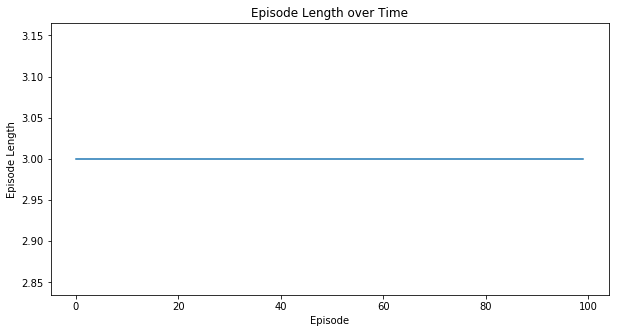

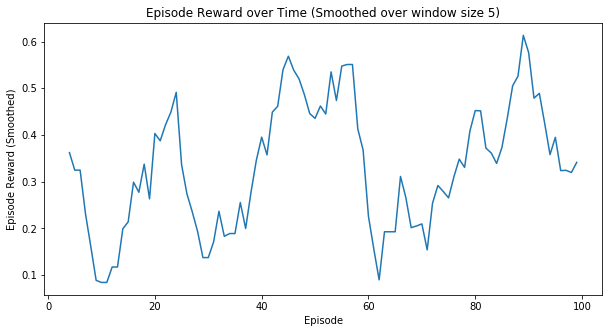

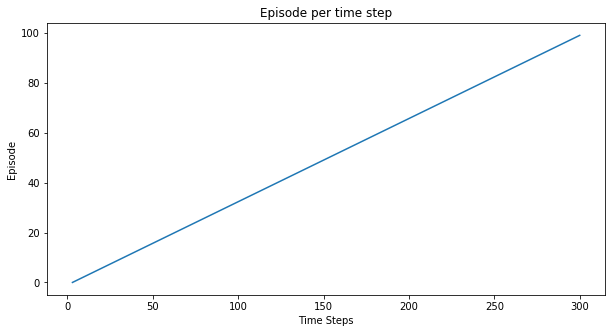

(<matplotlib.figure.Figure at 0x23e12c28b70>,
 <matplotlib.figure.Figure at 0x23e1da6bf60>)

In [115]:
plotting.plot_episode_stats(stats, smoothing_window=5)

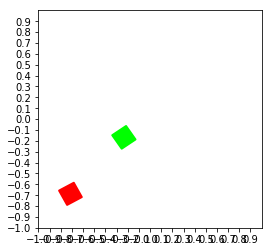

(array([0., 0., 0.], dtype=float32), array([1., 1., 1.], dtype=float32))
[-0.48467686 -0.12104822  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.05; reward = 0.05


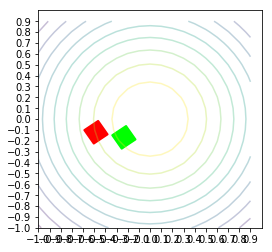

(array([0., 0., 0.], dtype=float32), array([1., 1., 1.], dtype=float32))
[-0.14063127  0.33241912  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]]
Progress = 0.70; reward = 0.65


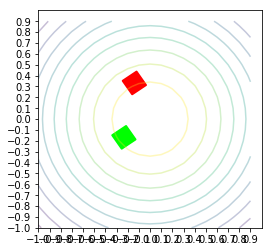

(array([0., 0., 0.], dtype=float32), array([1., 1., 1.], dtype=float32))
[ 0.01571526 -0.21489776  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]]
Progress = 0.39; reward = -0.31


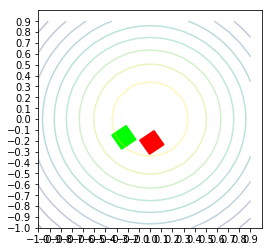

In [113]:
past_envs[0].env.replay(verbose = True)

In [96]:
np.random.choice(2)

0

In [97]:
[1, -1] [np.random.choice(2)]

-1